<a href="https://colab.research.google.com/github/OlegBogutsky/nn2022/blob/main/Lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Творче завдання
-----
##Виконав Богуцький Олег, КН-31

###Аналіз сканів головного мозку
----
#Хід роботи

Імпорутємно необхідні бібліотеки.

In [6]:
import tensorflow as tf
import numpy as np

Завантажуємо набор даних.

In [7]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  24.9M      0  0:00:03  0:00:03 --:--:-- 24.9M


Видаляємо непотрібні папки.

In [8]:
!rm -r aclImdb/train/unsup

Створюємо з текстів набори даних, та розбиваємо їх на групи.

In [9]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 625
Number of batches in raw_val_ds: 157
Number of batches in raw_test_ds: 782


Видаляємо непотрібні символи та векторизуємо дані.

In [10]:
from tensorflow.keras.layers import TextVectorization
import string
import re

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


max_features = 20000
embedding_dim = 128
sequence_length = 500


vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

text_ds = raw_train_ds.map(lambda x, y: x)

vectorize_layer.adapt(text_ds)

In [11]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

Описуємо модель.

In [12]:
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(None,), dtype="int64")

x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)


predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Тренуємо модель.

In [19]:
epochs = 3

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
625/625 [==============================] - 121s 194ms/step - loss: 0.0659 - accuracy: 0.9769 - val_loss: 0.6301 - val_accuracy: 0.8440
Epoch 2/3
625/625 [==============================] - 121s 194ms/step - loss: 0.0384 - accuracy: 0.9855 - val_loss: 0.9871 - val_accuracy: 0.8206
Epoch 3/3
625/625 [==============================] - 121s 193ms/step - loss: 0.0301 - accuracy: 0.9901 - val_loss: 0.7636 - val_accuracy: 0.8588


In [21]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

Будуємо графіки та метрики.

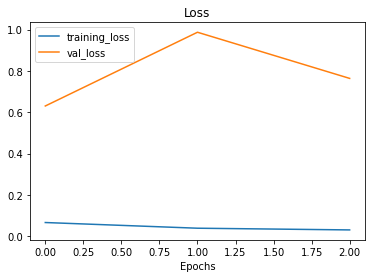

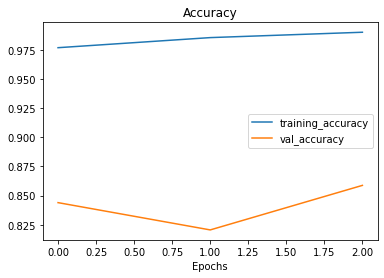

In [22]:
plot_loss_curves(history)

In [14]:
predictions = model.predict(test_ds)

In [63]:
a = np.empty(0)
for string_, int_ in test_ds:
    a = np.append(a, int_)

predictions = np.around(predictions.flatten());

from sklearn.metrics import confusion_matrix

TN, FP, FN, TP = confusion_matrix(a, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  11539
False Positive(FP) =  2781
True Negative(TN)  =  9719
False Negative(FN) =  961
Accuracy of the binary classification = 0.850


Висновок: у цій самостійній роботі я навчився працювати з текстовою інформацією, підготовляти тексти, векторизувати їх та будувати моделі для обробки текстів.